In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [4096,2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_4096_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b25_targets_t1_native_k5_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 834)
(884582, 3)
validation
(154411, 834)
(154411, 3)
test
(115112, 834)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 834)]             0         


 dense (Dense)               (None, 4096)              3420160   


 dense_1 (Dense)             (None, 2048)              8390656   


 dense_2 (Dense)             (None, 1024)              2098176   


 dense_3 (Dense)             (None, 512)               524800    


 dense_4 (Dense)             (None, 256)               131328    


 dense_5 (Dense)             (None, 128)               32896     


 dense_6 (Dense)             (None, 3)                 387       


Total params: 14598403 (55.69 MB)


Trainable params: 14598403 (55.69 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 3:15 - loss: 1.4655 - STD: 0.2350 - MAE: 0.4753

2/9 [=====>........................] - ETA: 7s - loss: 1.2885 - STD: 0.1514 - MAE: 0.4586  

3/9 [=========>....................] - ETA: 6s - loss: 1.2199 - STD: 0.1386 - MAE: 0.4484

4/9 [============>.................] - ETA: 5s - loss: 1.1947 - STD: 0.1405 - MAE: 0.4423

5/9 [===============>..............] - ETA: 4s - loss: 1.1853 - STD: 0.1449 - MAE: 0.4384

6/9 [===================>..........] - ETA: 3s - loss: 1.1801 - STD: 0.1480 - MAE: 0.4358

7/9 [======================>.......] - ETA: 2s - loss: 1.1742 - STD: 0.1496 - MAE: 0.4338

8/9 [=========================>....] - ETA: 1s - loss: 1.1675 - STD: 0.1497 - MAE: 0.4324

9/9 [==============================] - ETA: 0s - loss: 1.1612 - STD: 0.1481 - MAE: 0.4316

9/9 [==============================] - 57s 4s/step - loss: 1.1612 - STD: 0.1481 - MAE: 0.4316 - val_loss: 1.0819 - val_STD: 0.1115 - val_MAE: 0.4281


Epoch 2/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0829 - STD: 0.1115 - MAE: 0.4282

2/9 [=====>........................] - ETA: 7s - loss: 1.0786 - STD: 0.0975 - MAE: 0.4302

3/9 [=========>....................] - ETA: 6s - loss: 1.0776 - STD: 0.0835 - MAE: 0.4323

4/9 [============>.................] - ETA: 5s - loss: 1.0786 - STD: 0.0708 - MAE: 0.4341

5/9 [===============>..............] - ETA: 4s - loss: 1.0808 - STD: 0.0609 - MAE: 0.4357

6/9 [===================>..........] - ETA: 3s - loss: 1.0829 - STD: 0.0547 - MAE: 0.4369

7/9 [======================>.......] - ETA: 1s - loss: 1.0842 - STD: 0.0515 - MAE: 0.4376

8/9 [=========================>....] - ETA: 1s - loss: 1.0850 - STD: 0.0503 - MAE: 0.4380

9/9 [==============================] - ETA: 0s - loss: 1.0850 - STD: 0.0504 - MAE: 0.4381

9/9 [==============================] - 10s 1s/step - loss: 1.0850 - STD: 0.0504 - MAE: 0.4381 - val_loss: 1.0800 - val_STD: 0.0598 - val_MAE: 0.4368


Epoch 3/10000


1/9 [==>...........................] - ETA: 10s - loss: 1.0809 - STD: 0.0598 - MAE: 0.4370

2/9 [=====>........................] - ETA: 7s - loss: 1.0781 - STD: 0.0632 - MAE: 0.4360 

3/9 [=========>....................] - ETA: 6s - loss: 1.0765 - STD: 0.0665 - MAE: 0.4352

4/9 [============>.................] - ETA: 5s - loss: 1.0758 - STD: 0.0699 - MAE: 0.4346

5/9 [===============>..............] - ETA: 4s - loss: 1.0757 - STD: 0.0733 - MAE: 0.4340

6/9 [===================>..........] - ETA: 3s - loss: 1.0762 - STD: 0.0766 - MAE: 0.4336

7/9 [======================>.......] - ETA: 2s - loss: 1.0765 - STD: 0.0796 - MAE: 0.4332

8/9 [=========================>....] - ETA: 1s - loss: 1.0770 - STD: 0.0822 - MAE: 0.4328

9/9 [==============================] - ETA: 0s - loss: 1.0774 - STD: 0.0843 - MAE: 0.4325

9/9 [==============================] - 10s 1s/step - loss: 1.0774 - STD: 0.0843 - MAE: 0.4325 - val_loss: 1.0779 - val_STD: 0.1006 - val_MAE: 0.4297


Epoch 4/10000


1/9 [==>...........................] - ETA: 10s - loss: 1.0801 - STD: 0.1006 - MAE: 0.4301

2/9 [=====>........................] - ETA: 7s - loss: 1.0782 - STD: 0.0991 - MAE: 0.4300 

3/9 [=========>....................] - ETA: 6s - loss: 1.0775 - STD: 0.0969 - MAE: 0.4304

4/9 [============>.................] - ETA: 5s - loss: 1.0764 - STD: 0.0940 - MAE: 0.4307

5/9 [===============>..............] - ETA: 4s - loss: 1.0758 - STD: 0.0906 - MAE: 0.4312

6/9 [===================>..........] - ETA: 2s - loss: 1.0756 - STD: 0.0869 - MAE: 0.4317

7/9 [======================>.......] - ETA: 2s - loss: 1.0753 - STD: 0.0833 - MAE: 0.4323

8/9 [=========================>....] - ETA: 1s - loss: 1.0753 - STD: 0.0799 - MAE: 0.4327

9/9 [==============================] - ETA: 0s - loss: 1.0753 - STD: 0.0771 - MAE: 0.4332

9/9 [==============================] - 10s 1s/step - loss: 1.0753 - STD: 0.0771 - MAE: 0.4332 - val_loss: 1.0753 - val_STD: 0.0549 - val_MAE: 0.4365


Epoch 5/10000


1/9 [==>...........................] - ETA: 10s - loss: 1.0761 - STD: 0.0549 - MAE: 0.4366

2/9 [=====>........................] - ETA: 7s - loss: 1.0757 - STD: 0.0562 - MAE: 0.4363 

3/9 [=========>....................] - ETA: 6s - loss: 1.0757 - STD: 0.0579 - MAE: 0.4361

4/9 [============>.................] - ETA: 4s - loss: 1.0753 - STD: 0.0597 - MAE: 0.4358

5/9 [===============>..............] - ETA: 3s - loss: 1.0749 - STD: 0.0615 - MAE: 0.4355

6/9 [===================>..........] - ETA: 2s - loss: 1.0748 - STD: 0.0632 - MAE: 0.4353

7/9 [======================>.......] - ETA: 2s - loss: 1.0745 - STD: 0.0648 - MAE: 0.4350

8/9 [=========================>....] - ETA: 1s - loss: 1.0745 - STD: 0.0662 - MAE: 0.4348

9/9 [==============================] - ETA: 0s - loss: 1.0744 - STD: 0.0676 - MAE: 0.4346

9/9 [==============================] - 10s 1s/step - loss: 1.0744 - STD: 0.0676 - MAE: 0.4346 - val_loss: 1.0737 - val_STD: 0.0809 - val_MAE: 0.4326


Epoch 6/10000


1/9 [==>...........................] - ETA: 8s - loss: 1.0757 - STD: 0.0809 - MAE: 0.4330

2/9 [=====>........................] - ETA: 7s - loss: 1.0751 - STD: 0.0815 - MAE: 0.4328

3/9 [=========>....................] - ETA: 6s - loss: 1.0744 - STD: 0.0818 - MAE: 0.4326

4/9 [============>.................] - ETA: 5s - loss: 1.0740 - STD: 0.0819 - MAE: 0.4325

5/9 [===============>..............] - ETA: 4s - loss: 1.0738 - STD: 0.0818 - MAE: 0.4324

6/9 [===================>..........] - ETA: 3s - loss: 1.0739 - STD: 0.0815 - MAE: 0.4325

7/9 [======================>.......] - ETA: 2s - loss: 1.0740 - STD: 0.0808 - MAE: 0.4326

8/9 [=========================>....] - ETA: 1s - loss: 1.0739 - STD: 0.0800 - MAE: 0.4328

9/9 [==============================] - ETA: 0s - loss: 1.0739 - STD: 0.0790 - MAE: 0.4329

9/9 [==============================] - 10s 1s/step - loss: 1.0739 - STD: 0.0790 - MAE: 0.4329 - val_loss: 1.0733 - val_STD: 0.0689 - val_MAE: 0.4343


Epoch 7/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0728 - STD: 0.0689 - MAE: 0.4342

2/9 [=====>........................] - ETA: 7s - loss: 1.0729 - STD: 0.0683 - MAE: 0.4343

3/9 [=========>....................] - ETA: 6s - loss: 1.0732 - STD: 0.0681 - MAE: 0.4344

4/9 [============>.................] - ETA: 5s - loss: 1.0736 - STD: 0.0681 - MAE: 0.4344

5/9 [===============>..............] - ETA: 4s - loss: 1.0735 - STD: 0.0681 - MAE: 0.4344

6/9 [===================>..........] - ETA: 3s - loss: 1.0736 - STD: 0.0683 - MAE: 0.4344

7/9 [======================>.......] - ETA: 2s - loss: 1.0738 - STD: 0.0685 - MAE: 0.4344

8/9 [=========================>....] - ETA: 1s - loss: 1.0737 - STD: 0.0689 - MAE: 0.4344

9/9 [==============================] - ETA: 0s - loss: 1.0737 - STD: 0.0693 - MAE: 0.4343

9/9 [==============================] - 10s 1s/step - loss: 1.0737 - STD: 0.0693 - MAE: 0.4343 - val_loss: 1.0731 - val_STD: 0.0744 - val_MAE: 0.4335


Epoch 8/10000


1/9 [==>...........................] - ETA: 10s - loss: 1.0736 - STD: 0.0744 - MAE: 0.4336

2/9 [=====>........................] - ETA: 7s - loss: 1.0740 - STD: 0.0751 - MAE: 0.4335 

3/9 [=========>....................] - ETA: 6s - loss: 1.0736 - STD: 0.0756 - MAE: 0.4334

4/9 [============>.................] - ETA: 5s - loss: 1.0737 - STD: 0.0760 - MAE: 0.4334

5/9 [===============>..............] - ETA: 4s - loss: 1.0738 - STD: 0.0761 - MAE: 0.4333

6/9 [===================>..........] - ETA: 2s - loss: 1.0737 - STD: 0.0761 - MAE: 0.4333

7/9 [======================>.......] - ETA: 2s - loss: 1.0737 - STD: 0.0760 - MAE: 0.4333

8/9 [=========================>....] - ETA: 1s - loss: 1.0737 - STD: 0.0757 - MAE: 0.4334

9/9 [==============================] - ETA: 0s - loss: 1.0736 - STD: 0.0755 - MAE: 0.4334

9/9 [==============================] - 10s 1s/step - loss: 1.0736 - STD: 0.0755 - MAE: 0.4334 - val_loss: 1.0731 - val_STD: 0.0728 - val_MAE: 0.4338


Epoch 9/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0739 - STD: 0.0728 - MAE: 0.4339

2/9 [=====>........................] - ETA: 7s - loss: 1.0734 - STD: 0.0725 - MAE: 0.4338

3/9 [=========>....................] - ETA: 6s - loss: 1.0734 - STD: 0.0722 - MAE: 0.4339

4/9 [============>.................] - ETA: 5s - loss: 1.0735 - STD: 0.0720 - MAE: 0.4339

5/9 [===============>..............] - ETA: 4s - loss: 1.0736 - STD: 0.0718 - MAE: 0.4339

6/9 [===================>..........] - ETA: 3s - loss: 1.0736 - STD: 0.0718 - MAE: 0.4340

7/9 [======================>.......] - ETA: 2s - loss: 1.0736 - STD: 0.0718 - MAE: 0.4339

8/9 [=========================>....] - ETA: 1s - loss: 1.0737 - STD: 0.0719 - MAE: 0.4340

9/9 [==============================] - ETA: 0s - loss: 1.0736 - STD: 0.0720 - MAE: 0.4339

9/9 [==============================] - 10s 1s/step - loss: 1.0736 - STD: 0.0720 - MAE: 0.4339 - val_loss: 1.0731 - val_STD: 0.0732 - val_MAE: 0.4337


Epoch 10/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0735 - STD: 0.0732 - MAE: 0.4337

2/9 [=====>........................] - ETA: 7s - loss: 1.0738 - STD: 0.0736 - MAE: 0.4337

3/9 [=========>....................] - ETA: 5s - loss: 1.0739 - STD: 0.0738 - MAE: 0.4337

4/9 [============>.................] - ETA: 4s - loss: 1.0738 - STD: 0.0739 - MAE: 0.4337

5/9 [===============>..............] - ETA: 3s - loss: 1.0736 - STD: 0.0739 - MAE: 0.4336

6/9 [===================>..........] - ETA: 2s - loss: 1.0734 - STD: 0.0739 - MAE: 0.4336

7/9 [======================>.......] - ETA: 2s - loss: 1.0735 - STD: 0.0740 - MAE: 0.4336

8/9 [=========================>....] - ETA: 1s - loss: 1.0734 - STD: 0.0740 - MAE: 0.4336

9/9 [==============================] - ETA: 0s - loss: 1.0735 - STD: 0.0740 - MAE: 0.4336

9/9 [==============================] - 10s 1s/step - loss: 1.0735 - STD: 0.0740 - MAE: 0.4336 - val_loss: 1.0731 - val_STD: 0.0739 - val_MAE: 0.4336


Epoch 11/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0741 - STD: 0.0739 - MAE: 0.4338

2/9 [=====>........................] - ETA: 7s - loss: 1.0744 - STD: 0.0734 - MAE: 0.4339

3/9 [=========>....................] - ETA: 6s - loss: 1.0740 - STD: 0.0728 - MAE: 0.4339

4/9 [============>.................] - ETA: 5s - loss: 1.0738 - STD: 0.0725 - MAE: 0.4339

5/9 [===============>..............] - ETA: 4s - loss: 1.0737 - STD: 0.0723 - MAE: 0.4339

6/9 [===================>..........] - ETA: 3s - loss: 1.0737 - STD: 0.0722 - MAE: 0.4339

7/9 [======================>.......] - ETA: 2s - loss: 1.0737 - STD: 0.0723 - MAE: 0.4339

8/9 [=========================>....] - ETA: 1s - loss: 1.0737 - STD: 0.0724 - MAE: 0.4339

9/9 [==============================] - ETA: 0s - loss: 1.0735 - STD: 0.0725 - MAE: 0.4338

9/9 [==============================] - 10s 1s/step - loss: 1.0735 - STD: 0.0725 - MAE: 0.4338 - val_loss: 1.0731 - val_STD: 0.0744 - val_MAE: 0.4335


Epoch 12/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0733 - STD: 0.0744 - MAE: 0.4335

2/9 [=====>........................] - ETA: 7s - loss: 1.0729 - STD: 0.0745 - MAE: 0.4334

3/9 [=========>....................] - ETA: 6s - loss: 1.0734 - STD: 0.0745 - MAE: 0.4335

4/9 [============>.................] - ETA: 5s - loss: 1.0734 - STD: 0.0744 - MAE: 0.4335

5/9 [===============>..............] - ETA: 3s - loss: 1.0734 - STD: 0.0743 - MAE: 0.4335

6/9 [===================>..........] - ETA: 2s - loss: 1.0735 - STD: 0.0741 - MAE: 0.4336

7/9 [======================>.......] - ETA: 2s - loss: 1.0735 - STD: 0.0739 - MAE: 0.4336

8/9 [=========================>....] - ETA: 1s - loss: 1.0734 - STD: 0.0737 - MAE: 0.4336

9/9 [==============================] - ETA: 0s - loss: 1.0735 - STD: 0.0737 - MAE: 0.4337

9/9 [==============================] - 10s 1s/step - loss: 1.0735 - STD: 0.0737 - MAE: 0.4337 - val_loss: 1.0731 - val_STD: 0.0735 - val_MAE: 0.4337


Epoch 13/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0735 - STD: 0.0735 - MAE: 0.4337

2/9 [=====>........................] - ETA: 6s - loss: 1.0736 - STD: 0.0733 - MAE: 0.4337

3/9 [=========>....................] - ETA: 5s - loss: 1.0738 - STD: 0.0732 - MAE: 0.4338

4/9 [============>.................] - ETA: 4s - loss: 1.0737 - STD: 0.0729 - MAE: 0.4338

5/9 [===============>..............] - ETA: 3s - loss: 1.0737 - STD: 0.0728 - MAE: 0.4338

6/9 [===================>..........] - ETA: 2s - loss: 1.0738 - STD: 0.0728 - MAE: 0.4338

7/9 [======================>.......] - ETA: 2s - loss: 1.0735 - STD: 0.0728 - MAE: 0.4338

8/9 [=========================>....] - ETA: 1s - loss: 1.0736 - STD: 0.0729 - MAE: 0.4338

9/9 [==============================] - ETA: 0s - loss: 1.0735 - STD: 0.0729 - MAE: 0.4338

9/9 [==============================] - 10s 1s/step - loss: 1.0735 - STD: 0.0729 - MAE: 0.4338 - val_loss: 1.0731 - val_STD: 0.0731 - val_MAE: 0.4337


Epoch 14/10000


1/9 [==>...........................] - ETA: 10s - loss: 1.0730 - STD: 0.0731 - MAE: 0.4336

2/9 [=====>........................] - ETA: 6s - loss: 1.0735 - STD: 0.0733 - MAE: 0.4337 

3/9 [=========>....................] - ETA: 5s - loss: 1.0738 - STD: 0.0734 - MAE: 0.4338

4/9 [============>.................] - ETA: 4s - loss: 1.0737 - STD: 0.0733 - MAE: 0.4338

5/9 [===============>..............] - ETA: 3s - loss: 1.0735 - STD: 0.0733 - MAE: 0.4337

6/9 [===================>..........] - ETA: 2s - loss: 1.0734 - STD: 0.0735 - MAE: 0.4337

7/9 [======================>.......] - ETA: 2s - loss: 1.0735 - STD: 0.0737 - MAE: 0.4337

8/9 [=========================>....] - ETA: 1s - loss: 1.0737 - STD: 0.0739 - MAE: 0.4337

9/9 [==============================] - ETA: 0s - loss: 1.0736 - STD: 0.0738 - MAE: 0.4336

9/9 [==============================] - 10s 1s/step - loss: 1.0736 - STD: 0.0738 - MAE: 0.4336 - val_loss: 1.0731 - val_STD: 0.0724 - val_MAE: 0.4338


Epoch 15/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0730 - STD: 0.0724 - MAE: 0.4338

2/9 [=====>........................] - ETA: 7s - loss: 1.0736 - STD: 0.0720 - MAE: 0.4339

3/9 [=========>....................] - ETA: 6s - loss: 1.0735 - STD: 0.0717 - MAE: 0.4340

4/9 [============>.................] - ETA: 5s - loss: 1.0735 - STD: 0.0717 - MAE: 0.4339

5/9 [===============>..............] - ETA: 4s - loss: 1.0735 - STD: 0.0720 - MAE: 0.4339

6/9 [===================>..........] - ETA: 3s - loss: 1.0736 - STD: 0.0725 - MAE: 0.4338

7/9 [======================>.......] - ETA: 2s - loss: 1.0736 - STD: 0.0727 - MAE: 0.4338

8/9 [=========================>....] - ETA: 1s - loss: 1.0737 - STD: 0.0728 - MAE: 0.4338

9/9 [==============================] - ETA: 0s - loss: 1.0736 - STD: 0.0728 - MAE: 0.4338

9/9 [==============================] - 10s 1s/step - loss: 1.0736 - STD: 0.0728 - MAE: 0.4338 - val_loss: 1.0731 - val_STD: 0.0725 - val_MAE: 0.4338


Epoch 16/10000


1/9 [==>...........................] - ETA: 10s - loss: 1.0727 - STD: 0.0725 - MAE: 0.4337

2/9 [=====>........................] - ETA: 7s - loss: 1.0729 - STD: 0.0730 - MAE: 0.4336 

3/9 [=========>....................] - ETA: 5s - loss: 1.0733 - STD: 0.0735 - MAE: 0.4336

4/9 [============>.................] - ETA: 4s - loss: 1.0735 - STD: 0.0737 - MAE: 0.4336

5/9 [===============>..............] - ETA: 3s - loss: 1.0735 - STD: 0.0737 - MAE: 0.4337

6/9 [===================>..........] - ETA: 2s - loss: 1.0736 - STD: 0.0736 - MAE: 0.4337

7/9 [======================>.......] - ETA: 2s - loss: 1.0737 - STD: 0.0734 - MAE: 0.4337

8/9 [=========================>....] - ETA: 1s - loss: 1.0736 - STD: 0.0732 - MAE: 0.4337

9/9 [==============================] - ETA: 0s - loss: 1.0735 - STD: 0.0731 - MAE: 0.4337

9/9 [==============================] - 10s 1s/step - loss: 1.0735 - STD: 0.0731 - MAE: 0.4337 - val_loss: 1.0731 - val_STD: 0.0728 - val_MAE: 0.4338


Epoch 17/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0726 - STD: 0.0728 - MAE: 0.4336

2/9 [=====>........................] - ETA: 7s - loss: 1.0731 - STD: 0.0735 - MAE: 0.4336

3/9 [=========>....................] - ETA: 6s - loss: 1.0734 - STD: 0.0740 - MAE: 0.4336

4/9 [============>.................] - ETA: 5s - loss: 1.0735 - STD: 0.0739 - MAE: 0.4336

5/9 [===============>..............] - ETA: 4s - loss: 1.0734 - STD: 0.0736 - MAE: 0.4336

6/9 [===================>..........] - ETA: 3s - loss: 1.0735 - STD: 0.0732 - MAE: 0.4337

7/9 [======================>.......] - ETA: 2s - loss: 1.0736 - STD: 0.0731 - MAE: 0.4338

8/9 [=========================>....] - ETA: 1s - loss: 1.0736 - STD: 0.0732 - MAE: 0.4337

9/9 [==============================] - ETA: 0s - loss: 1.0736 - STD: 0.0733 - MAE: 0.4337

9/9 [==============================] - 10s 1s/step - loss: 1.0736 - STD: 0.0733 - MAE: 0.4337 - val_loss: 1.0731 - val_STD: 0.0749 - val_MAE: 0.4335


Epoch 18/10000


1/9 [==>...........................] - ETA: 10s - loss: 1.0724 - STD: 0.0749 - MAE: 0.4332

2/9 [=====>........................] - ETA: 7s - loss: 1.0737 - STD: 0.0747 - MAE: 0.4335 

3/9 [=========>....................] - ETA: 5s - loss: 1.0736 - STD: 0.0740 - MAE: 0.4336

4/9 [============>.................] - ETA: 4s - loss: 1.0737 - STD: 0.0735 - MAE: 0.4337

5/9 [===============>..............] - ETA: 3s - loss: 1.0736 - STD: 0.0732 - MAE: 0.4337

6/9 [===================>..........] - ETA: 2s - loss: 1.0737 - STD: 0.0732 - MAE: 0.4338

7/9 [======================>.......] - ETA: 2s - loss: 1.0736 - STD: 0.0732 - MAE: 0.4337

8/9 [=========================>....] - ETA: 1s - loss: 1.0735 - STD: 0.0732 - MAE: 0.4337

9/9 [==============================] - ETA: 0s - loss: 1.0736 - STD: 0.0733 - MAE: 0.4337

9/9 [==============================] - 10s 1s/step - loss: 1.0736 - STD: 0.0733 - MAE: 0.4337 - val_loss: 1.0731 - val_STD: 0.0726 - val_MAE: 0.4338


Epoch 19/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0727 - STD: 0.0726 - MAE: 0.4336

2/9 [=====>........................] - ETA: 7s - loss: 1.0737 - STD: 0.0726 - MAE: 0.4338

3/9 [=========>....................] - ETA: 6s - loss: 1.0736 - STD: 0.0728 - MAE: 0.4338

4/9 [============>.................] - ETA: 4s - loss: 1.0736 - STD: 0.0731 - MAE: 0.4338

5/9 [===============>..............] - ETA: 3s - loss: 1.0736 - STD: 0.0733 - MAE: 0.4337

6/9 [===================>..........] - ETA: 2s - loss: 1.0735 - STD: 0.0733 - MAE: 0.4337

7/9 [======================>.......] - ETA: 2s - loss: 1.0734 - STD: 0.0733 - MAE: 0.4337

8/9 [=========================>....] - ETA: 1s - loss: 1.0735 - STD: 0.0732 - MAE: 0.4337

9/9 [==============================] - ETA: 0s - loss: 1.0735 - STD: 0.0732 - MAE: 0.4337

9/9 [==============================] - 10s 1s/step - loss: 1.0735 - STD: 0.0732 - MAE: 0.4337 - val_loss: 1.0731 - val_STD: 0.0729 - val_MAE: 0.4337


Epoch 20/10000


1/9 [==>...........................] - ETA: 9s - loss: 1.0739 - STD: 0.0729 - MAE: 0.4339

2/9 [=====>........................] - ETA: 7s - loss: 1.0736 - STD: 0.0728 - MAE: 0.4338

3/9 [=========>....................] - ETA: 6s - loss: 1.0736 - STD: 0.0729 - MAE: 0.4338

4/9 [============>.................] - ETA: 5s - loss: 1.0735 - STD: 0.0730 - MAE: 0.4338

5/9 [===============>..............] - ETA: 4s - loss: 1.0734 - STD: 0.0732 - MAE: 0.4337

6/9 [===================>..........] - ETA: 3s - loss: 1.0736 - STD: 0.0735 - MAE: 0.4337

7/9 [======================>.......] - ETA: 2s - loss: 1.0736 - STD: 0.0735 - MAE: 0.4337

8/9 [=========================>....] - ETA: 1s - loss: 1.0736 - STD: 0.0733 - MAE: 0.4337

9/9 [==============================] - ETA: 0s - loss: 1.0735 - STD: 0.0732 - MAE: 0.4337

9/9 [==============================] - 10s 1s/step - loss: 1.0735 - STD: 0.0732 - MAE: 0.4337 - val_loss: 1.0731 - val_STD: 0.0727 - val_MAE: 0.4338


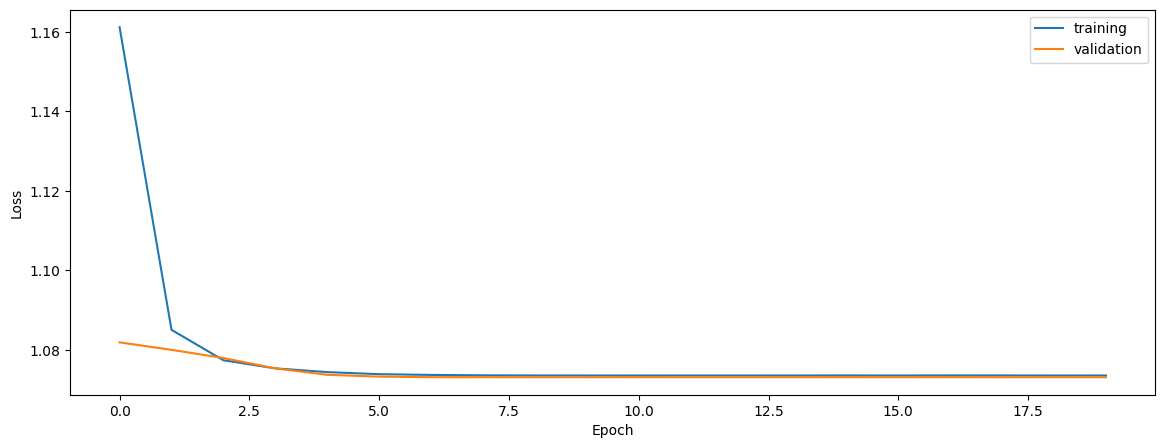

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.41240269415384895


0.41309233150487984


0.41550837445270694


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.5406490088210187


0.5430259483756725


0.5514561763552932


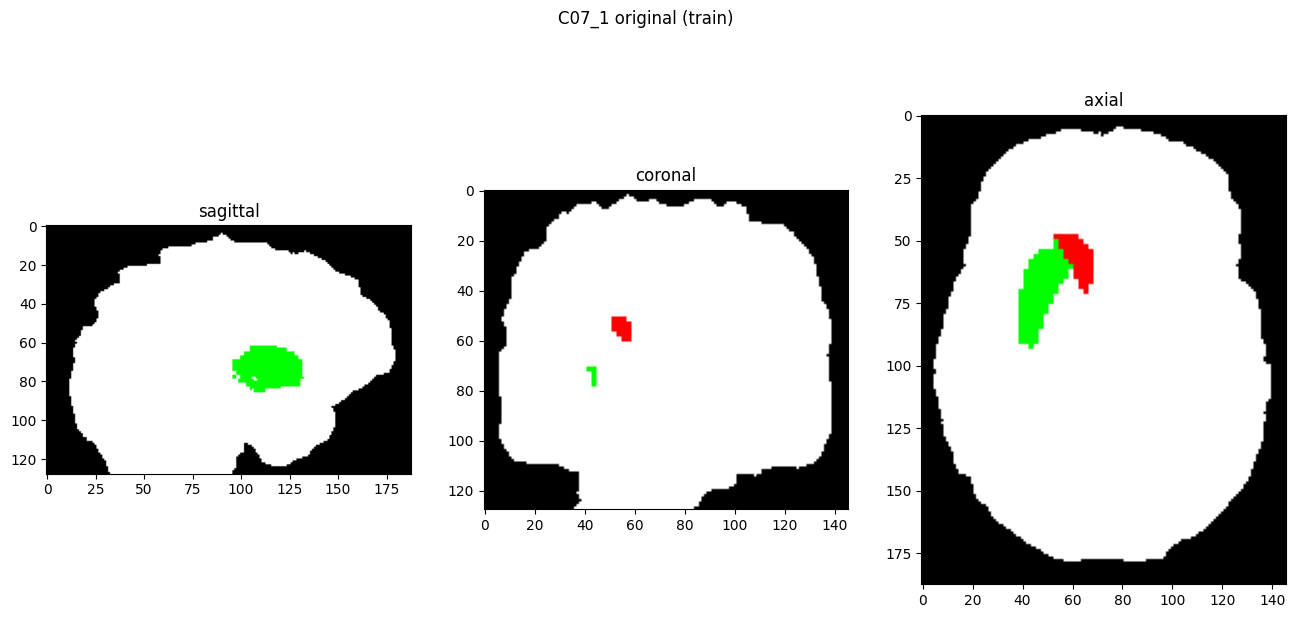

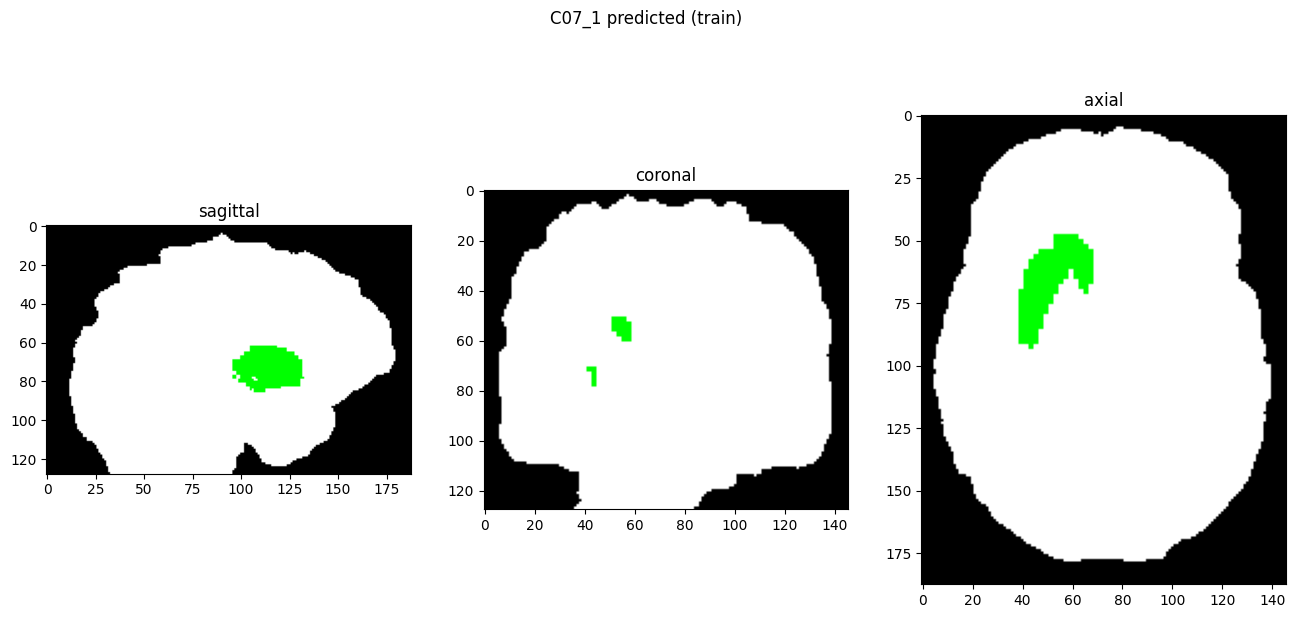

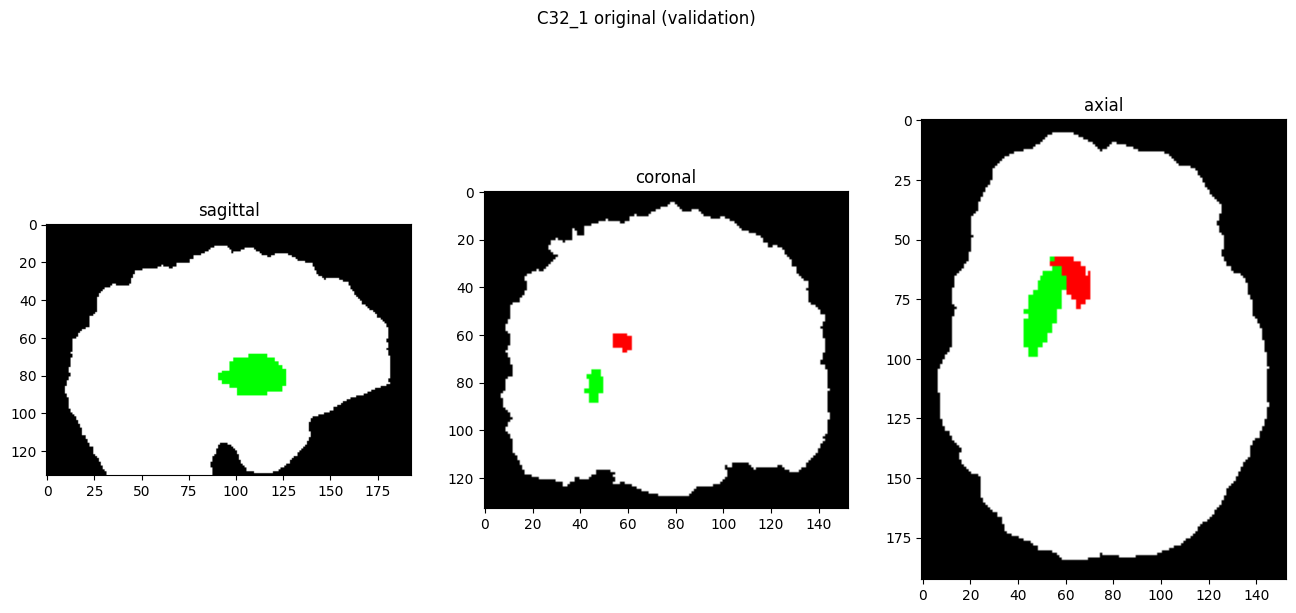

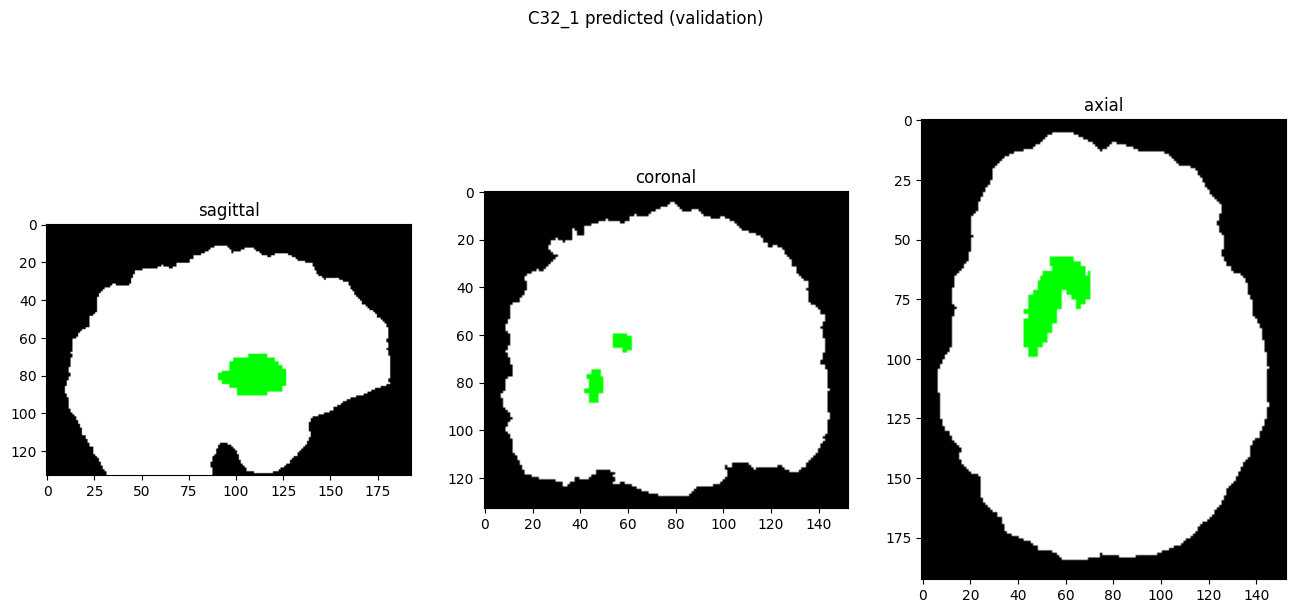

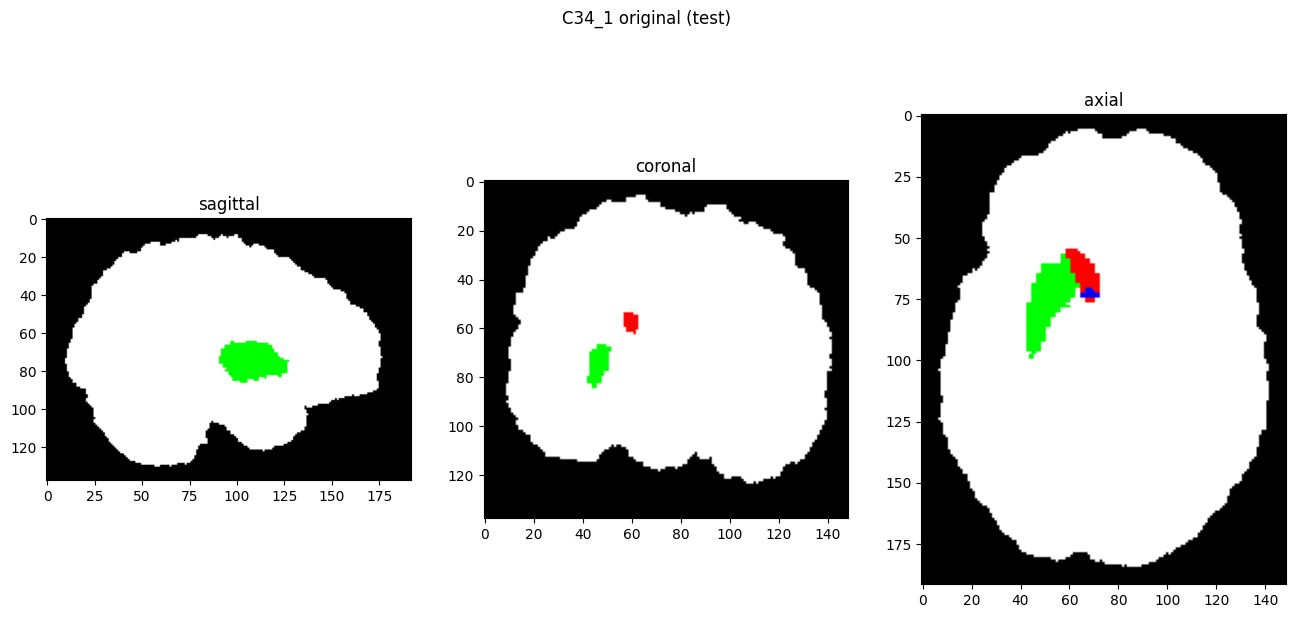

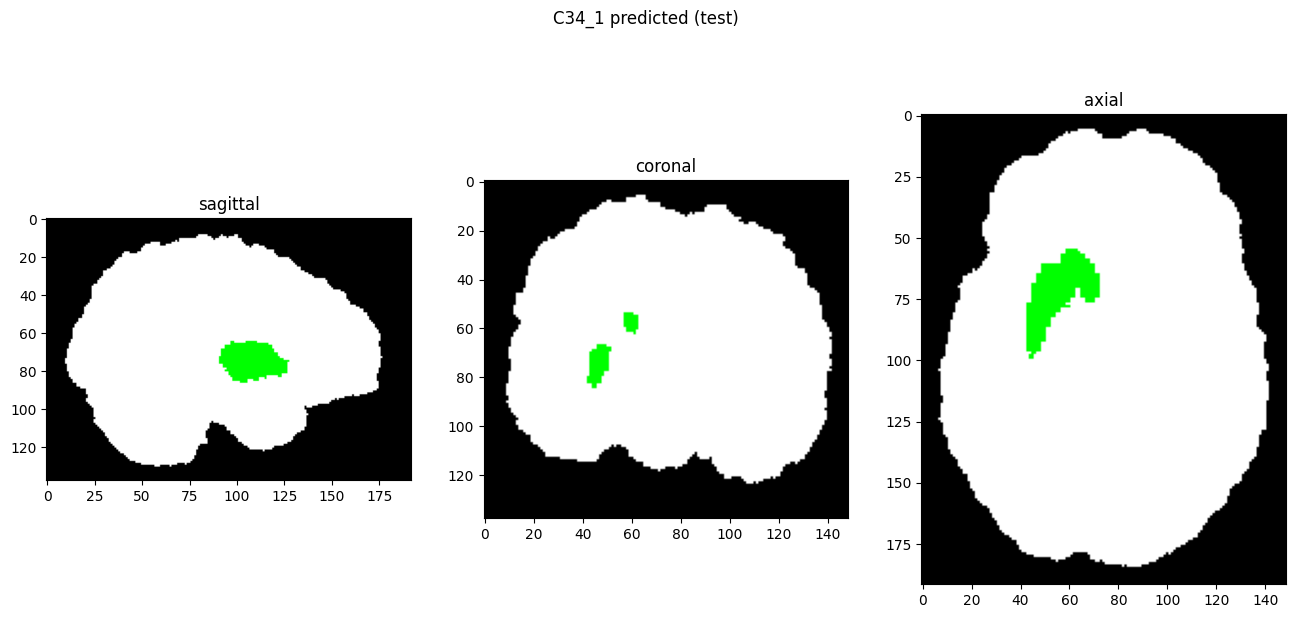

In [9]:
showResults(model, gen, threshold=0)